write in markdwon an intdocution to the prject that uses cnns to to do anamoly detection on gyrocsope data to detect user from others which can implmented as part of continous authentification system. 

# Continous Authentication Using Siamese Networks and One Class SVM

Hi this notebook goes through the process of training a siamese network to detect user from others. The data used is the gyroscope data from the UCI HAR dataset. The data is preprocessed and then fed into a siamese network. The siamese network is then used to train a one class SVM to detect the user from others. The one class SVM is then used to detect the user from others in real time. The data is then visualized using t-SNE.

## Data

The data used is the gyroscope data from the UCI HAR dataset. The data is preprocessed and then fed into a siamese network. The siamese network is then used to train a one class SVM to detect the user from others. The one class SVM is then used to detect the user from others in real time. The data is then visualized using t-SNE.

## Siamese Network

The siamese network is a neural network that takes two inputs and outputs a similarity score. The similarity score is then used to train a one class SVM to detect the user from others. The siamese network is trained using the contrastive loss function. The contrastive loss function is used to train the siamese network to output a similarity score of 0 for two inputs that are the same and a similarity score of 1 for two inputs that are different. The siamese network is trained using the contrastive loss function. The contrastive loss function is used to train the siamese network to output a similarity score of 0 for two inputs that are the same and a similarity score of 1 for two inputs that are different.

## One Class SVM

The one class SVM is a machine learning algorithm that is used to detect anomalies. 



In [ ]:
# Standard
from pathlib import Path
import os
import sys
import warnings
import random
import dataclasses
import math
import multiprocessing as mp
import keras
import  numpy as np
import pandas as pd
import torch
from keras import backend as K
from keras.models import Model
from keras.models import load_model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
import copy
from sklearn import metrics
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
# training CNN imports
from torch import nn, optim
from torch.nn import CrossEntropyLoss, MSELoss
from math import floor
import torch.nn.functional as F
# from arff2pandas import a2p
from keras.layers import (
    Dense,
    Input,
    Conv1D,
    MaxPooling1D,
    Flatten,
    Lambda,
    Conv2D,
    MaxPooling2D,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling1D,
    Activation
)
from pathlib import Path

# Extra
import pandas as pd
import numpy as np
from dataclasses import asdict
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, make_scorer, auc
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.utils import resample as sk_resample
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import animation, rc
from tqdm.auto import tqdm
from IPython.display import HTML
import math
#for graph colors
MAGENTA = (202/255, 18/255, 125/255)


Using TensorFlow backend.


In [ ]:
# utility function to generate cross-validation scenarios for training saimese network  
def utils_generate_cv_scenarios(df_ocsvm_train_valid,samples_per_subject_train,samples_per_subject_test,deep_model,limit_test_samples=False,limit_train_samples=False,model_variant="1d"):
    seed=2020
    subjects = list(df_ocsvm_train_valid["subject"].unique())
    for owner in subjects:
        #number of samples per session (experiment)
        n_sessions=len(df_ocsvm_train_valid.query("subject == @owner")["session"].unique())
        #samples for training 
        samples_per_session_train =math.ceil(samples_per_subject_train / n_sessions)
        #samples for testing
        samples_per_session_test = math.ceil(samples_per_subject_test / n_sessions)

        df_owner_train = (
                    df_ocsvm_train_valid.query("subject == @owner")
                    .groupby("session", group_keys=False)
                    .apply(
                        lambda x: x.sample(
                            n=min(len(x), samples_per_session_train), random_state=2020
                        ).copy()
                    )
                )
        df_owner_train["label"] = 1
        df_owner_train["mask"] = -2  # To use as sklearn cv mask
        # Restrict amount of overall train samples. (For evaluation of Training Delay)
        if limit_train_samples:
            df_owner_train = df_owner_train.sample(
                n=min(len(df_owner_train), limit_train_samples), random_state=seed
            )

        df_valid = df_ocsvm_train_valid.copy()

        # Prepate Validation Data Owner
        # --------------------------------

        # Select random owner samples
        df_owner_valid = (
            df_valid.query("subject == @owner")
            .groupby("session", group_keys=False)
            .apply(
                lambda x: x.sample(n=min(len(x), samples_per_session_test), random_state=seed)
            )
            .copy()
        )
        df_owner_valid["label"] = 1
        df_owner_valid["mask"] = -1
        
        # Restrict amount of overall test samples. (For evaluation of Detection Delay)
        if limit_test_samples:
            df_owner_valid = df_owner_valid.sample(
                n=min(len(df_owner_valid), limit_test_samples), random_state=seed
            )
            

        # Select Impostors for attack scenarios
        impostors = [sub for sub in subjects if sub != owner]

        # Prepate Validation Data Impostors
        # --------------------------------

        # Select random samples from every impostors
        df_impostors = pd.DataFrame()
        for idx, impostor in enumerate(impostors):
            # Select impostor validation set
            df_impostor = (
                df_ocsvm_train_valid.query("subject == @impostor")
                .groupby("session", group_keys=False)
                .apply(
                    lambda x: x.sample(
                        n=min(len(x), samples_per_session_test), random_state=seed
                    ).copy()
                )
            )
            df_impostor["label"] = -1
            df_impostor["mask"] = idx
            df_impostors = pd.concat([df_impostors, df_impostor], ignore_index=True)
        # Concat training and validation data
        df_cv_scenarios = pd.concat(
            [df_owner_train, df_owner_valid, df_impostors], ignore_index=True
        )
        if deep_model:
                    df_cv_scenarios = utils_generate_deep_features(
                        df_cv_scenarios, deep_model, model_variant
                    )
        yield(df_cv_scenarios, owner, impostors)

In [ ]:
def utils_generate_deep_features(df, model, variant):
    # Predict deep features
    X = np.stack(list(df["X"].values))
    
    # 2D Filter Model needs flat 4th dimension
    if variant == "2d":
        X = X.reshape((*X.shape, 1))
    
    X_pred = model.predict([X, X])

    # Overwrite original features
    df["X"] = [list(vect) for vect in X_pred]
    return df.copy()
    # to get nu and v table
def utils_cv_report(random_search, owner, impostors):
    """Transform the random_search.cv_results_ into nice formatted dataframe."""
    # Create report
    df_report = pd.DataFrame(random_search.cv_results_)

    # Add owner information
    df_report["owner"] = owner

    # Drop uninteressting columns
    drop_columns = [col for col in df_report.columns if "_train_" in col]
    drop_columns = drop_columns + [col for col in df_report.columns if col.startswith("split") and (col.endswith("recall") or col.endswith("precision") or col.endswith("f1") or col.endswith("roc_auc"))]
    drop_columns = drop_columns + ["params"]
    df_report = df_report.drop(columns=drop_columns)

    # Flip sign of eer (revert flip by sklearn scorer)
    eer_columns = [col for col in df_report.columns if col.endswith("_eer")]
    df_report[eer_columns] = df_report[eer_columns].abs()
    
    # Rename split result columns with impostor-ids used in split
    rename_cols = {}
    for idx, impostor in enumerate(impostors):
        to_rename_cols = [col for col in df_report.columns if col.startswith(f"split{idx}")]
        for col in to_rename_cols:
            rename_cols[col] = str(impostor)+col[len(f"split{idx}"):]
    df_report = df_report.rename(columns=rename_cols)      

    return df_report
def utils_create_cv_splits(cv_mask, seed):
    """"Create cross-validation mask with train-valid pairs.
    
    See e.g. https://stackoverflow.com/a/37591377
    
    Arguments:
        cv_mask {np.ndarray} --
        
    Return:
        {list} -- List of tuple: (<train indices>, <valid indices>)
        
    """
    train_idx_owner = np.where(cv_mask == -2)[0]
    valid_idx_owner = np.where(cv_mask == -1)[0]

    cv_splits = []
    for idx in range(cv_mask.max() + 1):#runs 29 times 
        #each times it takes one imposter indices
        # Impostor validation indices
        valid_idx_impostor = np.where(cv_mask == idx)[0]

        # Balance classes
        min_samples = min(valid_idx_owner.shape[0], valid_idx_impostor.shape[0]) #takes minimum n of samples (usually they're the same )
        np.random.seed(seed + idx)
        valid_idx_owner_samp = np.random.choice(
            valid_idx_owner, size=min_samples, replace=False
        )
        np.random.seed(seed + idx)
        valid_idx_impostor_samp = np.random.choice(
            valid_idx_impostor, size=min_samples, replace=False
        )

        # Concat owner & impostor validation indices
        valid_idx_both = np.hstack([valid_idx_owner_samp, valid_idx_impostor_samp])

        # Add train/valid pair to cv
        cv_splits.append((list(train_idx_owner), list(valid_idx_both)))

    return cv_splits
    
def utils_plot_randomsearch_results(df_results, n_top=1):
    # Prepare data for plotting
    df_plot = df_results[df_results["rank_test_eer"] <= n_top].rename(
        columns={
            "param_nu": r"$\nu$",
            "param_gamma": r"$\gamma$",
            "mean_test_accuracy": "Mean Test Acc.",
            "mean_test_eer": "Mean Test EER",
        }
    )
    df_plot["Mean Test EER"] = df_plot["Mean Test EER"] * -1  # Because fewer is more

    median_nu = df_plot[r"$\nu$"].median()
    median_gamma = df_plot[r"$\gamma$"].median()

    # Plot
    fig = plt.figure(figsize=(5.473 / 1.3, 2), dpi=180)
    g = sns.scatterplot(
        x=r"$\nu$",
        y=r"$\gamma$",
        data=df_plot,
        size="Mean Test EER",
        sizes=(7, 60),
        hue="Mean Test EER",
        alpha=1,
        #        palette="Blues",
        linewidth=0,
    )

    # Format Legend labels
    leg = g.get_legend()
    new_handles = [h for h in leg.legendHandles]
    new_labels = []
    for i, handle in enumerate(leg.legendHandles):
        label = handle.get_label()
        try:
            new_labels.append(f"{abs(float(label)):.3f}")
        except ValueError:
            new_labels.append("")

    # Plot mean values
    plt.plot(
        [-0.01, 0.31],
        [median_gamma, median_gamma],
        linestyle="dashed",
        linewidth=0.8,
        alpha=0.7,
        color="black",
    )
    plt.text(
        0.23,
        median_gamma * 1.7 ** 2,
        r"median($\gamma$)",
        fontsize=6,
        color="black",
        alpha=0.9,
    )
    plt.text(
        0.23,
        median_gamma * 1.2 ** 2,
        f"{median_gamma:.3f}",
        fontsize=5,
        color="black",
        alpha=0.9,
    )

    plt.plot(
        [median_nu, median_nu],
        [0.0001, 1000],
        linestyle="dashed",
        linewidth=0.8,
        alpha=0.7,
        color="black",
    )
    plt.text(
        median_nu + 0.005, 400, r"median($\nu$)", fontsize=6, color="black", alpha=0.9
    )
    plt.text(
        median_nu + 0.005, 200, f"{median_nu:.3f}", fontsize=5, color="black", alpha=0.9
    )

    # Adjust axes & legend
    plt.yscale("log")
    plt.ylim(0.0001, 1000)
    plt.xlim(0, 0.305)
    plt.legend(
        new_handles,
        new_labels,
        bbox_to_anchor=(1.02, 1),
        loc=2,
        borderaxespad=0.0,
        title="Mean EER per Owner\n(Validation Results)",
        title_fontsize=5,
    )

    fig.tight_layout()
    return fig,median_nu,median_gamma

In [ ]:
def build_pairs(df,samples_per,seed):
    SEED=seed
    # Limit samples per subject to lowest number of samples
    df = df.groupby("subject", group_keys=False).apply(
        lambda x: x.sample(min(len(x), samples_per), random_state=SEED)
    )
    
    df_pairs = None

    # Split samples subject wise 50:50
    # ---------------
    df_positives = None
    df_negatives = None

    for subject in df["subject"].unique():
        # Shuffle
        df_subj = df[df["subject"] == subject].sample(frac=1, random_state=SEED)

        # Make rows even
        if len(df_subj) % 2 != 0:
            df_subj = df_subj.iloc[:-1]

        half = len(df_subj) // 2

        df_positives = pd.concat([df_positives, df_subj.iloc[:half]])
        df_negatives = pd.concat([df_negatives, df_subj.iloc[half:]])

    # Positive Pairs
    # ---------------
    df_positive_left = None
    df_positive_right = None

    for subject in df_positives["subject"].unique():
        df_subj = df[df["subject"] == subject]
        # Make rows even
        if len(df_subj) % 2 != 0:
            df_subj = df_subj.iloc[:-1]

        # Split in half
        half = len(df_subj) // 2
        df_positive_left = pd.concat([df_positive_left, df_subj.iloc[:half]])
        df_positive_right = pd.concat([df_positive_right, df_subj.iloc[half:]])

    df_positive_left = df_positive_left.reset_index(drop=True)
    df_positive_right = df_positive_right.reset_index(drop=True)
    df_positive_left.columns = ["left_" + c for c in df_positive_left.columns]
    df_positive_right.columns = ["right_" + c for c in df_positive_right.columns]

    df_positives = pd.concat(
        [df_positive_left, df_positive_right],
        axis=1,
        sort=False,
        join_axes=[df_positive_left.index],
    )

    # Negative Pairs
    # ---------------
    # Make rows even
    if len(df_negatives) % 2 != 0:
        df_negatives = df_negatives.iloc[:-1]

    # Split in half
    half = len(df_negatives) // 2
    df_negative_left = df_negatives.iloc[half:].reset_index(drop=True)
    df_negative_right = df_negatives.iloc[:half].reset_index(drop=True)

    # Name columns
    df_negative_left.columns = ["left_" + c for c in df_negative_left.columns]
    df_negative_right.columns = ["right_" + c for c in df_negative_right.columns]

    # Combine
    df_negatives = pd.concat(
        [df_negative_left, df_negative_right],
        axis=1,
        sort=False,
        join_axes=[df_negative_left.index],
    )

    # Combine both Pairs
    # ---------------
    # Balance pairs
    min_len = min(len(df_positives), len(df_negatives))
    df_positives = df_positives.sample(n=min_len, random_state=SEED)
    df_negatives = df_negatives.sample(n=min_len, random_state=SEED)

    # Combine
    df_pairs = pd.concat([df_positives, df_negatives], sort=False)

    # Shuffle
    df_pairs = df_pairs.sample(frac=1, random_state=SEED).reset_index(drop=True)

    # Set Label
    df_pairs["label"] = np.where(
        df_pairs["left_subject"] == df_pairs["right_subject"], 1, 0
    )

    return df_pairs

# Initialize window size and model varient 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Read preprocessed files
sess_type='_Map'
hmog='HMOG_'
#WINDOW SIZE 
window_size=500
### Choose Model Varient ###
model_variant='2d'
#importing raw data bot dataframe and array
df_siamese_train = pd.read_pickle(f"/content/drive/My Drive/H-MOG Dataset/Hmog preprocessed files/{hmog}df_train_valid_{window_size}{sess_type}")
fil_y=f'/content/drive/My Drive/H-MOG Dataset/Hmog preprocessed files/{hmog}label_X_train_val_acc_gr_{window_size}{sess_type}.txt'
file_x=f'/content/drive/My Drive/H-MOG Dataset/Hmog preprocessed files/{hmog}X_train_val_acc_gr_{window_size}{sess_type}.txt'
detail_file=f'/content/drive/My Drive/H-MOG Dataset/Hmog preprocessed files/{hmog}data_details_{window_size}{sess_type}.txt'
### Read the array from disk
new_data = np.loadtxt(file_x)
data_labels=np.loadtxt(fil_y)
details=np.loadtxt(detail_file,delimiter=',',dtype=int)
#load details
n_windows=details[0]
min_window=details[2]
# original shape of the array
new_data = new_data.reshape((n_windows,window_size,6))
# Note that this returned a 2D array!
print (new_data.shape,min_window)

df_siamese_train # not scaled (RAW)

(7044, 500, 6) 425


,X,subject,session,task_type
0,"[[1.1474211, -2.3852234, 10.685322, 0.08216137...",100669,Map,1
1,"[[0.581791, 3.5224693, 8.643068, 0.14966199, 0...",100669,Map,1
2,"[[1.3084313, 4.209605000000001, 6.779182000000...",100669,Map,1
3,"[[-0.11432313, 4.7016134, 7.9307933, 0.1237002...",100669,Map,1
4,"[[0.38486794, 1.5472529, 10.3214035, -0.324064...",100669,Map,1
...,...,...,...,...
7039,"[[-0.84335756, 1.685518, 10.113108, -0.0781907...",220962,Map,1
7040,"[[-1.0959458, 2.6605566, 9.498994999999999, -0...",220962,Map,1
7041,"[[0.19153613, 1.3186066, 11.035474, 0.11545353...",220962,Map,1
7042,"[[-0.8074445, 1.2797008, 10.21965, 0.19853121,...",220962,Map,1


In [ ]:
len(new_data),data_labels

(7044, array([100669., 100669., 100669., ..., 220962., 220962., 220962.]))

Sample per session before reduction:
 


171538    1042
218719     966
207969     782
Name: subject, dtype: int64



Sample per session after reduction:



180679    340
207969    340
220962    340
Name: subject, dtype: int64

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Data columns (total 9 columns):
left_X             1700 non-null object
left_subject       1700 non-null object
left_session       1700 non-null object
left_task_type     1700 non-null int64
right_X            1700 non-null object
right_subject      1700 non-null object
right_session      1700 non-null object
right_task_type    1700 non-null int64
label              1700 non-null int64
dtypes: int64(3), object(6)
memory usage: 119.7+ KB


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.


None



Head:


,left_X,left_subject,left_session,left_task_type,right_X,right_subject,right_session,right_task_type,label
0,"[[-0.9995792, 5.1942205, 7.508815299999999, -0...",219303,Map,1,"[[-0.25139117, 4.0150760000000005, 7.9541364, ...",180679,Map,1,0
1,"[[-0.9175778, 3.5529952000000007, 7.8146744, 0...",219303,Map,1,"[[0.4189853, 3.5829230000000005, 9.138668, -0....",180679,Map,1,0
2,"[[4.56694, -0.65301853, 8.644864, 0.39736784, ...",201848,Map,1,"[[4.4663835, 0.08918401599999999, 8.001422, -0...",201848,Map,1,1
3,"[[-0.1388637, 4.1665095999999995, 8.27496, -0....",207969,Map,1,"[[-1.1438298, 3.8259343999999995, 7.9098440000...",151985,Map,1,0
4,"[[0.88046765, 4.420893700000001, 7.82784199999...",207969,Map,1,"[[-0.21368249999999997, 4.6279917, 7.969699, -...",207969,Map,1,1




Any NaN values?


left_X             0
left_subject       0
left_session       0
left_task_type     0
right_X            0
right_subject      0
right_session      0
right_task_type    0
label              0
dtype: int64




Distribution of Samples per Subjects in training Data


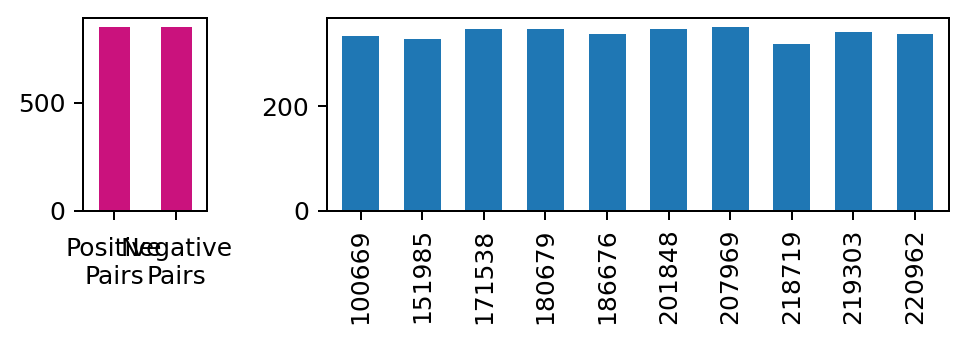

In [ ]:
#split data into pairs
samples_per=math.ceil(min_window*.8)
sample_per_val=min_window
SEED=2020
# Reduce observations/samples per
print("Sample per session before reduction:\n ")
display(df_siamese_train["subject"].value_counts().head(3))
df_siamese_val=df_siamese_train
df_siamese_train = df_siamese_train.groupby("subject", group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), samples_per), random_state=SEED)
)

print("\n\nSample per session after reduction:\n")
display(df_siamese_train["subject"].value_counts().head(3))


df_siamese_train_pairs = build_pairs(df_siamese_train,samples_per,SEED)
df_siamese_valid_pairs = build_pairs(df_siamese_val,sample_per_val,SEED-2)


print("DataFrame Info:")
display(df_siamese_train_pairs.info())

print("\n\nHead:")
display(df_siamese_train_pairs.head(5))

print("\n\nAny NaN values?")
display(df_siamese_train_pairs.isnull().sum(axis = 0))

df_left_sub = df_siamese_train_pairs.groupby("left_subject")["left_subject"].count()
df_right_sub = df_siamese_train_pairs.groupby("right_subject")["right_subject"].count()
df_temp = pd.concat([df_left_sub, df_right_sub])

print("\n\n\nDistribution of Samples per Subjects in training Data")

fig, axes = plt.subplots(
    ncols=2, nrows=1, figsize=(5.473, 2), dpi=180, gridspec_kw={"width_ratios": [1, 5]}
)
df_siamese_train_pairs["label"].value_counts().rename(
    index={0: "Negative\nPairs", 1: "Positive\nPairs"}
).plot.bar(ax=axes[0], rot=0, color=MAGENTA)
axes[0].tick_params(axis="x", which="major", pad=7)
df_temp.groupby(df_temp.index).sum().plot.bar(ax=axes[1], width=0.6)
fig.tight_layout()



In [ ]:
# Distance Function
def k_euclidean_dist(t):
    x = t[0]
    y = t[1]    
    return K.sqrt(K.sum(K.square(x - y), axis=-1, keepdims=True))
#Loss Function
def k_contrastive_loss(y_true, dist):
    """Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """
    margin = 1
    return K.mean(y_true * K.square(dist) + (1 - y_true) * K.square(K.maximum(margin - dist, 0)))
def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)
# build siamese network 
def build_model_1d(input_shape, filters):
    """
        Model architecture
    """
    # Define the tensors for the two input images
    left_inputs = Input(input_shape, name="left_inputs")
    right_inputs = Input(input_shape, name="right_inputs")

    # Convolutional Neural Network
    inputs = Input(input_shape, name="input")
    x = Conv1D(filters[0], 11, activation="elu", padding="same", name="conv1")(inputs)
    x = MaxPooling1D(pool_size=2, name="mp1")(x)
    x = Conv1D(filters[1], 5, activation="elu", padding="same", name="conv2")(x)
    x = MaxPooling1D(pool_size=2, name="mp2")(x)
    x = Conv1D(filters[2], 3, activation="elu", padding="same", name="conv3")(x)
    x = MaxPooling1D(pool_size=2, name="mp3")(x)
    x = Conv1D(filters[3], 3, activation="elu", padding="same", name="conv4")(x)
    x = MaxPooling1D(pool_size=2, name="mp5")(x)
    x = Flatten(name="flat")(x)

    # Generate the encodings (feature vectors) for the two images
    basemodel = Model(inputs, x, name="basemodel")

    # using same instance of "basemodel" to share weights between left/right networks
    encoded_l = basemodel(left_inputs)
    encoded_r = basemodel(right_inputs)

    # Add a customized layer to compute the absolute difference between the encodings
    distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

    siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)

    # return the model
    return siamese_net, basemodel
def build_model_2d(input_shape, filters):
    """
        Siamese CNN architecture with 3D input and 2D filters
    """
    # Define the tensors for the two input images
    left_inputs = Input(input_shape, name="left_inputs")
    right_inputs = Input(input_shape, name="right_inputs")

    # Convolutional Neural Network
    inputs = Input(input_shape, name="input")
    x = Conv2D(filters[0], (7, 7), padding="same", activation="tanh", name="conv1")(inputs)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp1")(x)
    x = Conv2D(filters[1], (5, 5), padding="same", activation="tanh", name="conv2")(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp2")(x)
    x = Conv2D(filters[2], (3, 3), padding="same", activation="tanh", name="conv3")(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp3")(x)
    x = Conv2D(filters[3], (3, 3), padding="same", activation="tanh", name="conv4")(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp4")(x)
    x = Flatten(name="flat")(x)

    # Basemodel instance
    basemodel = Model(inputs, x, name="basemodel")

    # using same instance of "basemodel" to share weights between left/right networks
    encoded_l = basemodel(left_inputs)
    encoded_r = basemodel(right_inputs)

    # Add a customized layer to compute the distance between the encodings
    distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    prediction = Dense(1,activation='sigmoid')(L1_distance)

    n_outputs=2
    outputs = Dense(n_outputs, activation='softmax')(L1_distance)

    # Combine into one net
    siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)

    # return the model
    return siamese_net, basemodel

# in_shape=(X_train[0].shape[1:])
# n_filters=[32, 64, 128, 64]#[64,128,256,256]
# model, basemodel  = build_model_2d(in_shape,n_filters)

# basemodel.summary()
# model.summary()



In [ ]:
# function to get differnet optimisers for training 
def get_optimizer(name, lr=None, decay=None):
    if name == "sgd":
        lr = lr if lr != None else 0.01
        decay = decay if decay != None else 0
        optimizer = SGD(lr=lr, decay=decay)
    elif name == "adam":
        lr = lr if lr != None else 0.001
        decay = decay if decay != None else 0
        optimizer = keras.optimizers.Adam(lr=lr, decay=decay)
    elif name == "rmsprop":
        lr = lr if lr != None else 0.001
        optimizer = RMSprop(lr=lr)
    else:
        raise BaseException("Error: Not a valid model name: 1d or 2d.")
    return optimizer
# Calculate the Equal Error Rate
def utils_eer(y_true, y_pred, return_threshold=False):
    """Calculate the Equal Error Rate.

    Based on https://stackoverflow.com/a/49555212, https://yangcha.github.io/EER-ROC/
    and https://scikit-learn.org/stable/modules/model_evaluation.html#implementing-your-own-scoring-object

    Arguments:
        y_true {np.array}  -- Actual labels
        y_pred {np.array}  -- Predicted labels or probability
        
    Returns:
        float              -- Equal Error Rate        
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    eer = brentq(lambda x: 1.0 - x - interp1d(fpr, tpr)(x), 0.0, 1.0)
    thresh = interp1d(fpr, thresholds)(eer)  # Calculated threshold, not needed for score
    if return_threshold:
        return eer, thresh
    else:
        return eer
def utils_save_plot(fig, filepath):
    """Save plot to file using certain layout and dpi."""
    fig.savefig(filepath, bbox_inches="tight", pad_inches=0.01, dpi=600)

def utils_plot_training_loss(history):
    MAGENTA = (202/255, 18/255, 125/255)
    """Plot Train/Valid Loss during Epochs."""
    fig = plt.figure(figsize=(5.473, 2.7), dpi=180)
    plt.plot(history.history["loss"], label="train", color="tab:blue")
    plt.plot(history.history["val_loss"], label="valid", color=MAGENTA)
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend(loc="upper right")
    fig.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    fig.tight_layout()
    return plt
def utils_plot_distance_hist(dist_positive, dist_negative, thres, desc, margin=None):
    """Plot histogramm of Euclidean Distances for Positive & Negative Pairs."""
    MAGENTA = (202/255, 18/255, 125/255)

    warnings.filterwarnings("ignore")

    # Plot Distributions
    plt.figure(figsize=(5.473, 0.6), dpi=180)
    bins = np.linspace(
        min(dist_positive.min(), dist_negative.min()),
        max(dist_positive.max(), dist_negative.max()),
        num=21,
    )
    g1 = sns.distplot(
        dist_positive,
        label="positive pairs",
        bins=bins,
        axlabel=False,
        hist_kws=dict(edgecolor="k", lw=0.5),
        kde_kws=dict(linewidth=0.8),
        color="tab:blue",
    )
    g2 = sns.distplot(
        dist_negative,
        label="negative pairs",
        bins=bins,
        hist_kws=dict(edgecolor="k", lw=0.5),
        kde_kws=dict(linewidth=0.8),
        color="tab:gray",
    )

    # Plot vertical lines
    if thres > 0:
        max_y = max(g1.get_ylim()[1], g2.get_ylim()[1])
        plt.axvline(x=thres, color=MAGENTA, linestyle="--", lw=0.8, alpha=0.7)
        plt.text(
            x=thres + 0.001,
            y=max_y * 0.65,
            s=f"EER Threshold\n({thres:.2f})",
            color=MAGENTA,
            weight="bold",
            fontsize=5,
            alpha=1
        )
        if margin:
            plt.axvline(x=margin, color=MAGENTA, linestyle="--", lw=0.8, alpha=0.7)
            plt.text(
                x=margin + 0.001,
                y=max_y * 0.15,
                s=f"Margin\n({margin})",
                color=MAGENTA,
                weight="bold",
                fontsize=5,
                alpha=1
            )

    # Legend
    plt.legend(
        loc="upper right",
        title=f"{desc} Distances",
        title_fontsize=5,
        fontsize=6,
    )

    warnings.filterwarnings("default")
    return plt
class MetricsCallback(keras.callbacks.Callback):
    """
    Custom Keras Callback function.
    
    Used to predict and plot distances for positive and negative pairs
    after each n-th epoch, along with some 'classification' metrics. 
    'Classification' here means to ability to distinguish between positive 
    and negative pairs using a threshold for the distance.
    
    Arguments:
        payload {tuple}           -- Datasets used for evaluation: (X_valid, y_valid, X_train, y_train)
        epoch_evaluate_freq {int} -- Frequency for evaluation. After every n-th epoch, 
                                     the results are evaluated and printed
        save_plots {boolean}      -- Do you want to save plots as PDF? Path is configured via global
                                     parameter REPORT_PATH.
    """

    def __init__(self, payload, epoch_evaluate_freq=1, save_plots=False):

        self.X_valid, self.y_valid, self.X_train, self.y_train = payload
        self.save_plots = save_plots
        self.epoch_evaluate_freq = epoch_evaluate_freq

        # Do we have train and valid set?
        self.sets = []
        if self.X_train:
            self.sets.append([self.X_train, self.y_train, "Train"])
        if self.X_valid:
            self.sets.append([self.X_valid, self.y_valid, "Valid"])

    def on_train_begin(self, logs={}):
        print(32 * "=" + f"[ Initial State ]" + 32 * "=", end="")
        for X, y, desc in self.sets:
#             print(X[0].shape,y.shape)
            self.evaluate(X, y, logs, desc, -1)

    def on_train_end(self, logs={}):
        print(32 * "=" + f"[ Final State ]" + 32 * "=", end="")
        for X, y, desc in self.sets:
            self.evaluate(X, y, logs, desc, -1)

    def on_epoch_end(self, epoch, logs={}):
        print(32 * "=" + f"[   Epoch {epoch}   ]" + 32 * "=", end="")
        if epoch % self.epoch_evaluate_freq == 0:  # Evaluate only every n-th epoch
            for X, y, desc in self.sets:
                self.evaluate(X, y, logs, desc, epoch)
        else:
            print(f"\n{ ', '.join([k + ': ' + f'{v:.3f}' for k,v in logs.items()]) }")

    def evaluate(self, X, y, logs, desc, epoch):
        # Predict
        y_score = self.model.predict(X)
        y_score_neg = y_score * -1  # lower distance means closer to positive class

        # Calc Metrics
        roc_val = metrics.roc_auc_score(y, y_score_neg)
        eer_val, thres = utils_eer(y, y_score_neg, True)
        y_pred = np.where(y_score_neg > thres, 1, 0)
        acc_val = metrics.accuracy_score(y, y_pred)
        f1_val = metrics.f1_score(y, y_pred)
#         print(roc_val,eer_val,acc_val,f1_val)
        print(
            f"\n{desc.upper()}: roc_auc: {roc_val:.4f}, "
            + f"eer: {eer_val:.4f}, thres: {thres*-1:.4f} => "
            + f"acc: {acc_val:.4f}, f1: {f1_val:.4f}\n"
            
        )

        # Plot distances
        mask = np.where(y == 1, True, False)
        dist_positive = y_score[mask]
        dist_negative = y_score[~mask]
        plt = utils_plot_distance_hist(
            dist_positive, dist_negative, thres * -1, desc=desc, margin=1
        )

        if self.save_plots:
            utils_save_plot(
                plt,
                REPORT_PATH
                / f"buech2019-siamese-MINE-epoch-{epoch+1}-{desc.lower()}.pdf",
            )

        plt.show()

In [ ]:


### ###
def prep_X_y_pair(df):
    
    X_left = np.stack(list(df["left_X"].values))
    X_right = np.stack(list(df["right_X"].values))
    
    X = [X_left, X_right]
    y = df["label"].values
    
    return X, y
X_train, y_train = prep_X_y_pair(df_siamese_train_pairs)
X_valid, y_valid = prep_X_y_pair(df_siamese_valid_pairs)

# 2D Filter Model needs flat 4th dimension
if model_variant == "2d":
    X_train[0] = X_train[0].reshape((*X_train[0].shape, 1))
    X_train[1] = X_train[1].reshape((*X_train[1].shape, 1))
    X_valid[0] = X_valid[0].reshape((*X_valid[0].shape, 1))
    X_valid[1] = X_valid[1].reshape((*X_valid[1].shape, 1))


print(
    f"Training samples:   {y_train.shape[0]}, shape: {X_train[0].shape},"
    + f" class balance: {np.unique(y_train, return_counts=True)}"
)
print(
    f"Validation samples: {y_valid.shape[0]}, shape: {X_valid[0].shape},"
    + f" class balance: {np.unique(y_valid, return_counts=True)}"
)

Training samples:   1700, shape: (1700, 500, 6, 1), class balance: (array([0, 1]), array([850, 850]))
Validation samples: 2120, shape: (2120, 500, 6, 1), class balance: (array([0, 1]), array([1060, 1060]))


================================[ Initial State ]================================
TRAIN: roc_auc: 0.7331, eer: 0.3329, thres: 1.1864 => acc: 0.6671, f1: 0.6671



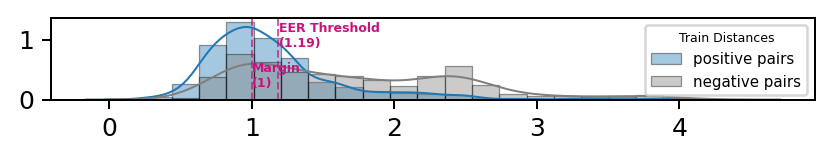

================================[   Epoch 0   ]================================
TRAIN: roc_auc: 0.8808, eer: 0.2047, thres: 0.4975 => acc: 0.7953, f1: 0.7951



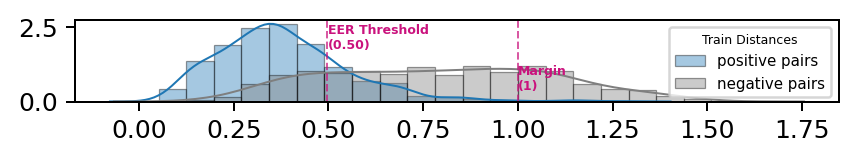

================================[   Epoch 1   ]================================
val_loss: 0.141, loss: 0.142
================================[   Epoch 2   ]================================
val_loss: 0.120, loss: 0.138
================================[   Epoch 3   ]================================
val_loss: 0.154, loss: 0.137
================================[   Epoch 4   ]================================
val_loss: 0.133, loss: 0.131
================================[   Epoch 5   ]================================
TRAIN: roc_auc: 0.9583, eer: 0.1000, thres: 0.5039 => acc: 0.9000, f1: 0.9000



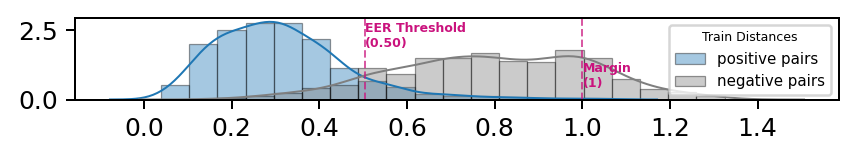

================================[   Epoch 6   ]================================
val_loss: 0.146, loss: 0.130
================================[   Epoch 7   ]================================
val_loss: 0.117, loss: 0.117
================================[   Epoch 8   ]================================
val_loss: 0.150, loss: 0.139
================================[   Epoch 9   ]================================
val_loss: 0.130, loss: 0.136
================================[   Epoch 10   ]================================
TRAIN: roc_auc: 0.9524, eer: 0.1110, thres: 0.7252 => acc: 0.8888, f1: 0.8888



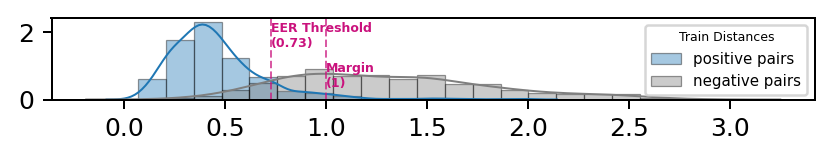

================================[   Epoch 11   ]================================
val_loss: 0.103, loss: 0.114
================================[   Epoch 12   ]================================
val_loss: 0.207, loss: 0.112
================================[   Epoch 13   ]================================
val_loss: 0.112, loss: 0.141
================================[   Epoch 14   ]================================
val_loss: 0.104, loss: 0.115
================================[   Epoch 15   ]================================
TRAIN: roc_auc: 0.9566, eer: 0.1082, thres: 0.3809 => acc: 0.8912, f1: 0.8911



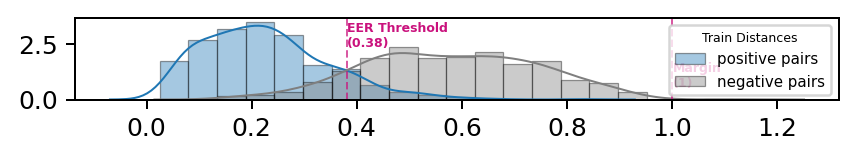

================================[   Epoch 16   ]================================
val_loss: 0.094, loss: 0.102
================================[   Epoch 17   ]================================
val_loss: 0.173, loss: 0.099
================================[   Epoch 18   ]================================
val_loss: 0.097, loss: 0.112
================================[   Epoch 19   ]================================
val_loss: 0.095, loss: 0.103
================================[   Epoch 20   ]================================
TRAIN: roc_auc: 0.9809, eer: 0.0537, thres: 0.5674 => acc: 0.9476, f1: 0.9476



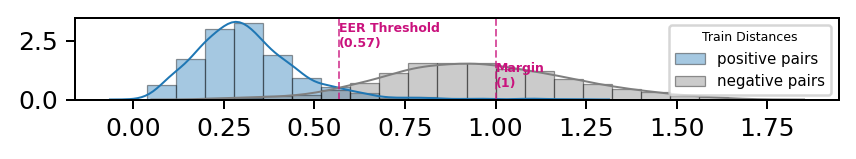

================================[   Epoch 21   ]================================
val_loss: 0.091, loss: 0.090
================================[   Epoch 22   ]================================
val_loss: 0.093, loss: 0.093
================================[   Epoch 23   ]================================
val_loss: 0.096, loss: 0.092
================================[   Epoch 24   ]================================
val_loss: 0.094, loss: 0.092
================================[   Epoch 25   ]================================
TRAIN: roc_auc: 0.9729, eer: 0.0741, thres: 0.5275 => acc: 0.9265, f1: 0.9264



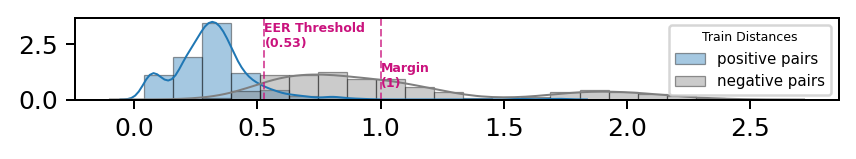

================================[   Epoch 26   ]================================
val_loss: 0.103, loss: 0.094
================================[   Epoch 27   ]================================
val_loss: 0.080, loss: 0.087
================================[   Epoch 28   ]================================
val_loss: 0.155, loss: 0.088
================================[   Epoch 29   ]================================
val_loss: 0.096, loss: 0.110
================================[ Final State ]================================
TRAIN: roc_auc: 0.9825, eer: 0.0518, thres: 0.4510 => acc: 0.9482, f1: 0.9482



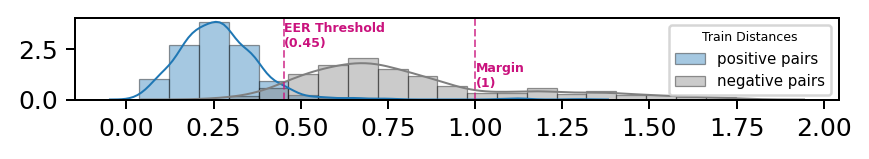

OSError: ignored

In [ ]:
optimizer = get_optimizer("adam", 0.002)
in_shape=(X_train[0].shape[1:])
n_filters=[32, 64, 128, 64]#[64,128,256,256]
#get model
if model_variant=='2d':
    model, basemodel  = build_model_2d(in_shape,n_filters)
else:
    model, basemodel  = build_model_1d(in_shape,n_filters)


# # Concat train & valid data
X_train_valid = [[], []]
X_train_valid[0] = np.vstack([X_train[0], X_valid[0]])
X_train_valid[1] = np.vstack([X_train[1], X_valid[1]])
y_train_valid = np.hstack([y_train, y_valid])

# Train
model.compile(loss=k_contrastive_loss, optimizer=optimizer)

history = model.fit(
    x=X_train_valid,
    y=y_train_valid,
    batch_size=100,
    epochs=30,
    verbose=0,
    validation_data=(X_valid, y_valid),
    callbacks=[MetricsCallback((None, None, X_train, y_train), epoch_evaluate_freq=5, save_plots=False)],
)

model.save(f'data_hapt/sia_model_-{model_variant}-{min_window}.h5')

print("Training History:")

plt = utils_plot_training_loss(history)
utils_save_plot(
    plt, f'data_hapt/{hmog}buech2019-siamese-MINE-{min_window}-{model_variant}-{hmog}-epoch-trainloss.pdf'
)
plt.show()



Mean distance: 0.57055
Max distance: 1.42377
Min distance: 0.00659


Histogram of Pair Distances:


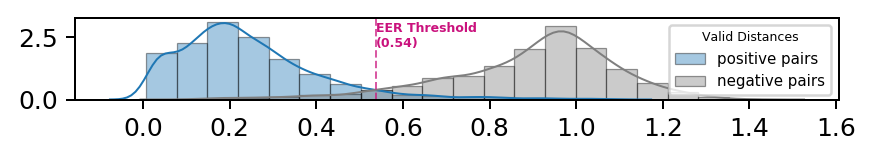

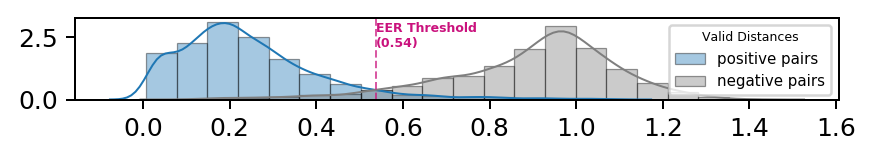

In [ ]:
# Predic validation set
dists = model.predict(X_valid)

# Stats
print(f"Mean distance: {dists.mean():.5f}")
print(f"Max distance: {dists.max():.5f}")
print(f"Min distance: {dists.min():.5f}\n")

# Histrogram
print("\nHistogram of Pair Distances:")
eer_val, thres = utils_eer(y_valid, dists, True)
mask = np.where(y_valid == 1, True, False)
dist_positive = dists[mask]
dist_negative = dists[~mask]
plt = utils_plot_distance_hist(dist_positive, dist_negative, thres, "Valid")
plt.show()
utils_save_plot(utils_plot_distance_hist(dist_positive, dist_negative, thres, "Valid"),f"sai_250_histogram_of_pairs_{window_size}_{model_variant}_{hmog}.png")

In [ ]:
# Extract one of the child networks
def load_deep_feature_model(model_path):
    warnings.filterwarnings("ignore")  # Silence depr. warnings

    # Copy of function from above. It's just more convenient for partially executing the notebook.
    def k_contrastive_loss(y_true, dist):
        """Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        """
        margin = 1
        return K.mean(
            y_true * K.square(dist)
            + (1 - y_true) * K.square(K.maximum(margin - dist, 0))
        )

    # Load Trained Siamese Network
    model = load_model(
        model_path,
        custom_objects={"k_contrastive_loss": k_contrastive_loss},
    )

    # Extract one of the child networks
    deep_feature_model = Model(
        inputs=model.get_input_at(0),  # get_layer("left_inputs").input,
        outputs=model.get_layer("basemodel").get_output_at(1),
    )

    return deep_feature_model

model=load_deep_feature_model(f'data_hapt/sia_model_-{model_variant}-{min_window}.h5')
deep_feature_model = Model(
        inputs=model.get_input_at(0),  # get_layer("left_inputs").input,
        outputs=model.get_layer("basemodel").get_output_at(1),
    )
deep_feature_model.summary()
#

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
left_inputs (InputLayer)     (None, 128, 6, 1)         0         
_________________________________________________________________
basemodel (Model)            (None, 512)               200512    
Total params: 200,512
Trainable params: 200,512
Non-trainable params: 0
_________________________________________________________________


In [ ]:

# #for one feture 
# new_new_data=new_data[:,:,0]
# print(new_new_data.shape)
def get_data(new_data,data_labels,min_window):
    win_sz=new_data.shape[1]
    x_train=np.zeros([1,win_sz,6])#36 windows 
    y_train=np.zeros([1])
    x_test=np.zeros([1,win_sz,6])#9 windows
    y_test=np.zeros([1])

    itr=0
    min_window=min_window

    train_idx=floor(min_window*.8)
    test_idx=min_window
    first_user=np.unique(data_labels)[0]
    x_train=np.append(x_train,new_data[np.where(data_labels==first_user)[0][:train_idx]],axis=0)
    x_test=np.append(x_test,new_data[np.where(data_labels==first_user)[0][train_idx:test_idx]],axis=0)
    y_train=np.append(y_train,data_labels[np.where(data_labels==first_user)[0][:train_idx]],axis=0)
    y_test=np.append(y_test,data_labels[np.where(data_labels==first_user)[0][train_idx:test_idx]],axis=0)
    x_train=np.delete(x_train,0,axis=0)
    x_test=np.delete(x_test,0,axis=0)
    y_train=np.delete(y_train,0,axis=0)
    y_test=np.delete(y_test,0,axis=0)
    for u,i in enumerate(np.unique(data_labels)[1:]):
#         print(i)
        x_train=np.append(x_train,new_data[np.where(data_labels==i)[0][:train_idx]],axis=0)
        x_test=np.append(x_test,new_data[np.where(data_labels==i)[0][train_idx:test_idx]],axis=0)
        y_train=np.append(y_train,data_labels[np.where(data_labels==i)[0][:train_idx]],axis=0)
        y_test=np.append(y_test,data_labels[np.where(data_labels==i)[0][train_idx:test_idx]],axis=0)
    return x_train,y_train,x_test,y_test
def create_dataset(df):

    sequences = df.astype(np.float32).tolist()
   
        
    dataset = torch.tensor(sequences).float() 

    n_seq, seq_len, n_features = (dataset).shape

    return dataset, seq_len, n_features
#getting x train and test
x_train,y_train,x_test,y_test=get_data(new_data,data_labels,min_window)
train_dataset, seq_len, n_features = create_dataset(x_train)
val_dataset, _, _ = create_dataset(x_test)

print(x_train.shape,val_dataset.shape)
deep_features_train = None

if model_variant=='2d':
    x_train=x_train.reshape(*x_train.shape,1)
    x_test=x_test.reshape(*x_test.shape,1)
    
for i in tqdm(range(len(x_train)),total=len(x_train),leave=False,desc="Predicting on Train"): 
    X=x_train[i]
    y=int(y_train[i])
    X=X.reshape(1,*X.shape)
   
    pred = deep_feature_model.predict([X, X])
    df_features = pd.DataFrame(pred)
    df_features["subject"] = y
    deep_features_train = pd.concat([deep_features_train, df_features])
        
deep_features_test = None
for i in tqdm(range(len(x_test)),total=len(x_test),leave=False,desc="Predicting on Test"):   
    X=x_test[i]
    y=int(y_test[i])
    X=X.reshape(1,*X.shape)
    pred = deep_feature_model.predict([X, X])
    df_features = pd.DataFrame(pred)
    df_features["subject"] = y
    deep_features_test = pd.concat([deep_features_test, df_features])
        
display(len(deep_features_train))
display(deep_features_test.head(3))
deep_features_train.to_csv('')


(13320, 128, 6) torch.Size([3340, 128, 6])


13320

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,subject
0,0.999661,0.999152,-0.994333,0.999868,-0.998411,0.999204,0.999692,0.999252,-0.991798,0.999689,...,0.999371,-0.996297,-0.998729,-0.998439,0.999811,-0.997316,0.998605,-0.998808,0.999725,100669
0,0.999655,0.999220,-0.993886,0.999873,-0.998492,0.999269,0.999752,0.999212,-0.992089,0.999711,...,0.999397,-0.996221,-0.998754,-0.998386,0.999811,-0.997324,0.998597,-0.998798,0.999720,100669
0,0.999681,0.999235,-0.993839,0.999865,-0.998501,0.999292,0.999789,0.999215,-0.992280,0.999728,...,0.999379,-0.996362,-0.998697,-0.998454,0.999808,-0.997386,0.998528,-0.998744,0.999708,100669


<module 'matplotlib.pyplot' from '/cs/home/khfy6uat/.virtualenv/lib64/python3.6/site-packages/matplotlib/pyplot.py'>

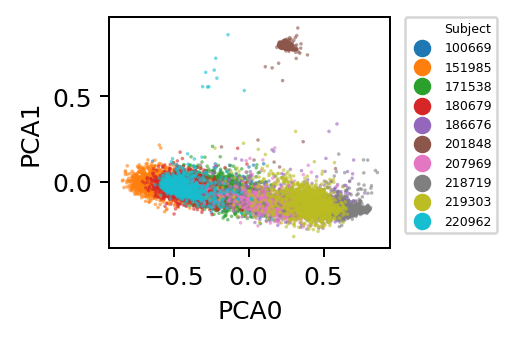

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

def plot_pca(df):
    # PCA
    pca = PCA(n_components=2)
    deep_transformed = pca.fit_transform(df.drop(columns=["subject"]).values)

    # Create df with data needed for chart only
    df_viz = df.copy()
    df_viz["PCA0"] = deep_transformed[:, 0]
    df_viz["PCA1"] = deep_transformed[:, 1]
    df_viz.drop(
        columns=[c for c in df_viz.columns if c not in ["PCA0", "PCA1", "subject"]]
    )

    # Generate color index for every subject
    df_viz["Subject"] = pd.Categorical(df_viz["subject"])
    df_viz["colors"] = df_viz["Subject"].cat.codes

    if len(df_viz["Subject"].unique()) <= 10:
        pal = sns.color_palette("tab10")
    else:
        pal = sns.color_palette("husl", 30)
        
    # Actual plot
    fig = plt.figure(figsize=(3, 2), dpi=180)
    sns.scatterplot(
        x="PCA0",
        y="PCA1",
        data=df_viz,
        hue="Subject",
        legend="full",
        palette=pal,
        s=2,
        linewidth=0,
        alpha=0.6,
    )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize=5)
    fig.tight_layout()
    return plt
plot_pca(deep_features_train)



## saimese as a classifier 




In [ ]:
# test if owner or not
def isit(dist,dist_owner):
    su=0
    for i in dist_owner:
        if all( i < dist):
            su=su+1
#     print(su)
    return su
        


In [ ]:
deep_features=deep_features_train
def test_thresh(deep_features_train,thres):
    best_all=np.empty(0)
    min_all=np.empty(0)

    best_all_owner=np.empty(0)
    min_all_owner=np.empty(0)


    avg_dist_owner_all=np.empty(0)
    avg_dist_all=np.empty(0)

    n_imposters=45#number of imposters to test against 
    n_owner=30

    for i,sub in tqdm(enumerate(deep_features["subject"].unique()),total=len((deep_features["subject"].unique())),leave=False,desc="Owner"):
#         print(sub)
        train_sample=deep_features.query("subject==@sub").sample(n=n_owner).drop(columns=['subject']).to_numpy()
        res=np.empty(0)
        res_owner=np.empty(0)
        avg_dist_owner=np.empty(0)
        avg_dist=np.empty(0)
        for idx,a in enumerate(train_sample):# for imposters 
            count=0
#             print(f"testing with subject: {sub} samples no: {idx}")
            test_sample=deep_features.query("subject!=@sub").sample(n=n_imposters).drop(columns=['subject']).to_numpy()
            test_sample_owner=deep_features.query("subject==@sub").sample(n=n_owner).drop(columns=['subject']).to_numpy()

            z,c=a,test_sample_owner
            x,y=a,test_sample

            dist=np.sqrt(np.sum(np.square(x - y), axis=-1, keepdims=True))
            dist_owner=np.sqrt(np.sum(np.square(z - c), axis=-1, keepdims=True))

            avg_dist_owner=np.append(avg_dist_owner,dist_owner.mean())
            avg_dist=np.append(avg_dist,dist.mean())

            got_true=int(sum(dist>thres))
            got_true_owner=int(sum(dist_owner<thres))

            res=np.append(res,got_true)
            res_owner=np.append(res_owner,got_true_owner)

#             print(f'Got {got_true} out of {n}')
    
#         print(f'##best for subject {sub} is {res.argmax()} with a score of {res.max()}  ({(res.max()/n)*100}%)##')
#         print(f'##MIN for subject {sub} is {res.argmin()} with a score of {res.min()}  ({(res.min()/n)*100})##')

#         print(f'##best SELF! for subject {sub} is {res_owner.argmax()} with a score of {res_owner.max()}  ({(res_owner.max()/n_o)*100}%)##')
#         print(f'##MIN SELF! for subject {sub} is {res_owner.argmin()} with a score of {res_owner.min()}  ({(res_owner.min()/n_o)*100})##')

#         print(f'AvERage dist : {avg_dist.mean()}')
#         print(f'AvERage dist OWNER: {avg_dist_owner.mean()}')


        best_all=np.append(best_all,res.max())
        min_all=np.append(min_all,res.min())

        best_all_owner=np.append(best_all_owner,res_owner.max())
        min_all_owner=np.append(min_all_owner,res_owner.min())

        avg_dist_all=np.append(avg_dist_all,avg_dist.mean())
        avg_dist_owner_all=np.append(avg_dist_owner_all,avg_dist_owner.mean())


    print(f'##################AVERAGE SCORE IS ---->  {best_all.mean()}  ({(best_all.mean()/n)*100}%)')
    print(f'##################AVERAGE MIN SCORE IS ---->  {min_all.mean()}  ({(min_all.mean()/n)*100}%)')

    print(f'###################AVERAGE SELF ! SCORE IS ---->  {best_all_owner.mean()}  ({(best_all_owner.mean()/n_o)*100}%)')
    print(f'###################AVERAGE SELF !MIN SCORE IS ---->  {min_all_owner.mean()}  ({(min_all_owner.mean()/n_o)*100}%)')

    print(f'######################AVERAGE  DIST SCORE IS ---->  {avg_dist_all.mean()}  ')
    print(f'######################AVERAGE SELF ! DIST SCORE IS ---->  {avg_dist_owner_all.mean()} ')
    return ((min_all.mean()/n)*100),((min_all_owner.mean()/n_o)*100)

min_all,min_owner=[],[]
range_thr=np.arange(0.1,0.9,0.1)
for thres in range_thr:
    x,y=test_thresh(deep_features_train,thres)
    print(f'thresh : \t{thres} \nmin all : {x}\nmin owner: {y}')
    min_all.append(x)
    min_owner.append(y)
    

##################AVERAGE SCORE IS ---->  45.0  (100.0%)
##################AVERAGE MIN SCORE IS ---->  41.1  (91.33333333333333%)
###################AVERAGE SELF ! SCORE IS ---->  12.1  (40.33333333333333%)
###################AVERAGE SELF !MIN SCORE IS ---->  0.0  (0.0%)
######################AVERAGE  DIST SCORE IS ---->  0.6987380616962909  
######################AVERAGE SELF ! DIST SCORE IS ---->  0.24684507885575294 
thresh : 	0.1 
min all : 91.33333333333333
min owner: 0.0


##################AVERAGE SCORE IS ---->  45.0  (100.0%)
##################AVERAGE MIN SCORE IS ---->  33.5  (74.44444444444444%)
###################AVERAGE SELF ! SCORE IS ---->  22.9  (76.33333333333333%)
###################AVERAGE SELF !MIN SCORE IS ---->  0.1  (0.33333333333333337%)
######################AVERAGE  DIST SCORE IS ---->  0.6979273673892021  
######################AVERAGE SELF ! DIST SCORE IS ---->  0.24510493055544794 
thresh : 	0.2 
min all : 74.44444444444444
min owner: 0.33333333333333337


##################AVERAGE SCORE IS ---->  44.0  (97.77777777777777%)
##################AVERAGE MIN SCORE IS ---->  27.8  (61.77777777777778%)
###################AVERAGE SELF ! SCORE IS ---->  28.4  (94.66666666666667%)
###################AVERAGE SELF !MIN SCORE IS ---->  1.6  (5.333333333333334%)
######################AVERAGE  DIST SCORE IS ---->  0.6893857532441616  
######################AVERAGE SELF ! DIST SCORE IS ---->  0.24405882161110637 
thresh : 	0.30000000000000004 
min all : 61.77777777777778
min owner: 5.333333333333334


##################AVERAGE SCORE IS ---->  41.8  (92.88888888888889%)
##################AVERAGE MIN SCORE IS ---->  20.0  (44.44444444444444%)
###################AVERAGE SELF ! SCORE IS ---->  29.9  (99.66666666666666%)
###################AVERAGE SELF !MIN SCORE IS ---->  2.5  (8.333333333333332%)
######################AVERAGE  DIST SCORE IS ---->  0.6946687438189982  
######################AVERAGE SELF ! DIST SCORE IS ---->  0.24953053401596845 
thresh : 	0.4 
min all : 44.44444444444444
min owner: 8.333333333333332


##################AVERAGE SCORE IS ---->  37.3  (82.88888888888889%)
##################AVERAGE MIN SCORE IS ---->  18.2  (40.44444444444444%)
###################AVERAGE SELF ! SCORE IS ---->  30.0  (100.0%)
###################AVERAGE SELF !MIN SCORE IS ---->  9.9  (33.0%)
######################AVERAGE  DIST SCORE IS ---->  0.6959813156425952  
######################AVERAGE SELF ! DIST SCORE IS ---->  0.2453705962020904 
thresh : 	0.5 
min all : 40.44444444444444
min owner: 33.0


##################AVERAGE SCORE IS ---->  35.3  (78.44444444444444%)
##################AVERAGE MIN SCORE IS ---->  13.2  (29.333333333333332%)
###################AVERAGE SELF ! SCORE IS ---->  30.0  (100.0%)
###################AVERAGE SELF !MIN SCORE IS ---->  14.4  (48.00000000000001%)
######################AVERAGE  DIST SCORE IS ---->  0.695311549961567  
######################AVERAGE SELF ! DIST SCORE IS ---->  0.24401623651385304 
thresh : 	0.6 
min all : 29.333333333333332
min owner: 48.00000000000001


##################AVERAGE SCORE IS ---->  32.7  (72.66666666666667%)
##################AVERAGE MIN SCORE IS ---->  6.6  (14.666666666666666%)
###################AVERAGE SELF ! SCORE IS ---->  30.0  (100.0%)
###################AVERAGE SELF !MIN SCORE IS ---->  14.4  (48.00000000000001%)
######################AVERAGE  DIST SCORE IS ---->  0.6921557047367097  
######################AVERAGE SELF ! DIST SCORE IS ---->  0.2455936186909676 
thresh : 	0.7000000000000001 
min all : 14.666666666666666
min owner: 48.00000000000001


##################AVERAGE SCORE IS ---->  29.0  (64.44444444444444%)
##################AVERAGE MIN SCORE IS ---->  4.9  (10.88888888888889%)
###################AVERAGE SELF ! SCORE IS ---->  30.0  (100.0%)
###################AVERAGE SELF !MIN SCORE IS ---->  24.1  (80.33333333333333%)
######################AVERAGE  DIST SCORE IS ---->  0.694705935627222  
######################AVERAGE SELF ! DIST SCORE IS ---->  0.243890958648175 
thresh : 	0.8 
min all : 10.88888888888889
min owner: 80.33333333333333


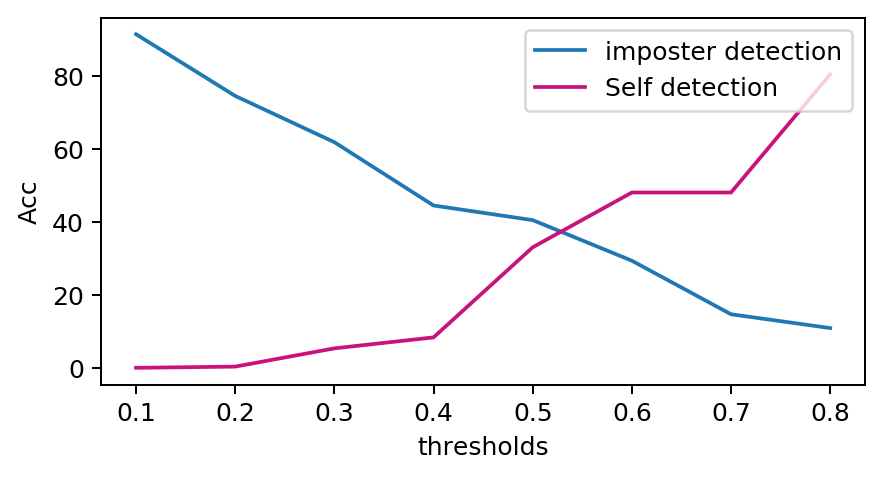

<Figure size 432x288 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(5.473, 2.7), dpi=180)
plt.plot(range_thr,min_all, label="imposter detection", color="tab:blue")
plt.plot(range_thr,min_owner, label="Self detection", color=MAGENTA)

plt.ylabel("Acc")
plt.xlabel("thresholds")
plt.legend(loc="upper right")
plt.show()
utils_save_plot(plt,f"sia_thr_{window_size}_{model_variant}.png")

# OCSVM 

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.model_selection import cross_validate, RandomizedSearchCV
#Parameters to search 
param_dist = {"gamma": np.logspace(-3, 3), "nu": np.linspace(0.0001, 0.3)} 
#utility function to calculate err
utils_eer_scorer = make_scorer(utils_eer, greater_is_better=False)

samples_per_subject_train=50 #Samples for training 
samples_per_subject_test=50#samples for testing 
df_results = None  # Will be filled with randomsearch scores


#loop through all users and create training data for each user 
for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_siamese_val,
            samples_per_subject_train=samples_per_subject_train,
            samples_per_subject_test=samples_per_subject_test,
            deep_model=deep_feature_model,
            model_variant=model_variant,
        ),
        desc="Owner",
        total=df_siamese_train["subject"].nunique(),
        leave=False,
    ):
        X = np.array(df_cv_scenarios["X"].values.tolist())
        y = df_cv_scenarios["label"].values
        SEED=2020


        train_valid_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        model = OneClassSVM(kernel="rbf")

        warnings.filterwarnings("ignore")
        random_search = RandomizedSearchCV(
            model,
            param_distributions=param_dist,
            cv=train_valid_cv,
            n_iter=50,
            refit=False,
            scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
            verbose=0,
            return_train_score=False,
            iid=False,
            error_score=np.nan,
            random_state=SEED,
        )

        random_search.fit(X, y)



        df_report = utils_cv_report(random_search, owner, impostors)
        df_results = pd.concat([df_results, df_report], sort=False)
df_results.to_csv(f"random_search_results_{window_size}_{model_variant}.csv", index=False)


Best results for each owner:


,owner,param_nu,param_gamma,rank_test_eer,mean_test_eer,std_test_eer,mean_test_accuracy,std_test_accuracy
2,201848,0.0857857,4.71487,1.0,0.047016,0.017885,0.970000,0.016997
33,218719,0.0368224,14.5635,1.0,0.141230,0.095271,0.901111,0.088248
46,220962,0.030702,59.6362,1.0,0.150342,0.047479,0.892222,0.052868
24,207969,0.104147,2.6827,1.0,0.154520,0.108288,0.874444,0.099232
0,151985,0.116388,0.00308884,1.0,0.155004,0.186529,0.871111,0.169669
20,219303,0.0613041,10.9854,1.0,0.162181,0.105851,0.877778,0.097727
27,180679,0.0368224,1.1514,1.0,0.194432,0.181409,0.834444,0.173276
4,171538,0.177592,0.00175751,1.0,0.215197,0.183982,0.807778,0.175168
32,100669,0.0857857,0.00232995,1.0,0.215919,0.138854,0.820000,0.125963
36,186676,0.140869,19.307,1.0,0.244779,0.101600,0.801111,0.112787





Most relevant statistics:


,mean_fit_time,mean_test_accuracy,std_test_accuracy,mean_test_eer,std_test_eer
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.001900,0.865000,0.111194,0.168062,0.116715
std,0.000281,0.051289,0.052401,0.054942,0.057264
min,0.001612,0.801111,0.016997,0.047016,0.017885
25%,0.001714,0.823611,0.090618,0.151387,0.096854
50%,0.001856,0.872778,0.106009,0.158593,0.107070
75%,0.001925,0.888611,0.158743,0.210005,0.170770
max,0.002587,0.970000,0.175168,0.244779,0.186529


NU: 0.07966530612244899
Gamma: 3.6987810793685596


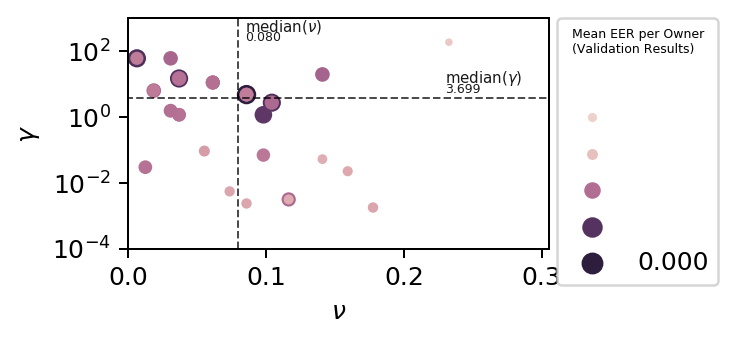

In [ ]:
print("Best results for each owner:")

display(
    df_results[df_results["rank_test_eer"] <= 1][
        [
            "owner",
            "param_nu",
            "param_gamma",
            "rank_test_eer",
            "mean_test_eer",
            "std_test_eer",
            "mean_test_accuracy",
            "std_test_accuracy",
        ]
    ].sort_values("mean_test_eer").head(10)
)

print("\n\n\nMost relevant statistics:")
display(
    df_results[df_results["rank_test_eer"] <= 1][
        [
            "mean_fit_time",
            "param_nu",
            "param_gamma",
            "mean_test_accuracy",
            "std_test_accuracy",
            "mean_test_eer",
            "std_test_eer",
        ]
    ].describe()
)
# utils_plot_randomsearch_results(df_results, 1)
fig,nu,gamma=utils_plot_randomsearch_results(df_results, 5)
print(f'NU: {nu}\nGamma: {gamma}')
utils_save_plot(fig,f"random_search_results_{window_size}_{model_variant}_{hmog}.png")

In [ ]:

#utility function to calculate err
utils_eer_scorer = make_scorer(utils_eer, greater_is_better=False)

samples_per_subject_train=2000#Samples for training 
samples_per_subject_test=400#samples for testing 
df_results_eval = None  # Will be filled with randomsearch scores


#loop through all users and create training data for each user 
for df_cv_scenarios, owner, impostors in tqdm(
        utils_generate_cv_scenarios(
            df_siamese_val,
            samples_per_subject_train=samples_per_subject_train,
            samples_per_subject_test=samples_per_subject_test,
            deep_model=deep_feature_model,
            model_variant=model_variant,
        ),
        desc="Owner",
        total=df_siamese_train["subject"].nunique(),
        leave=False,
    ):
        X = np.array(df_cv_scenarios["X"].values.tolist())
        y = df_cv_scenarios["label"].values
        SEED=2020


        train_valid_cv = utils_create_cv_splits(df_cv_scenarios["mask"].values, SEED)

        model = OneClassSVM(kernel="rbf", nu=nu, gamma=gamma)

        warnings.filterwarnings("ignore")
        scores = cross_validate(
            model,
            X,
            y,
            cv=train_valid_cv,
            scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
            verbose=0,
            return_train_score=True,
        )



        df_score = pd.DataFrame(scores)
        df_score["owner"] = owner
        df_score["train_eer"] = df_score["train_eer"].abs()  # Revert scorer's signflip
        df_score["test_eer"] = df_score["test_eer"].abs()
        df_results_eval = pd.concat([df_results_eval, df_score], axis=0)
df_results_eval.to_csv(f"random_search_results_eval_{window_size}_{model_variant}_{hmog}.csv", index=False)


Overall mean: 0.8304
Overall mean: 0.1983


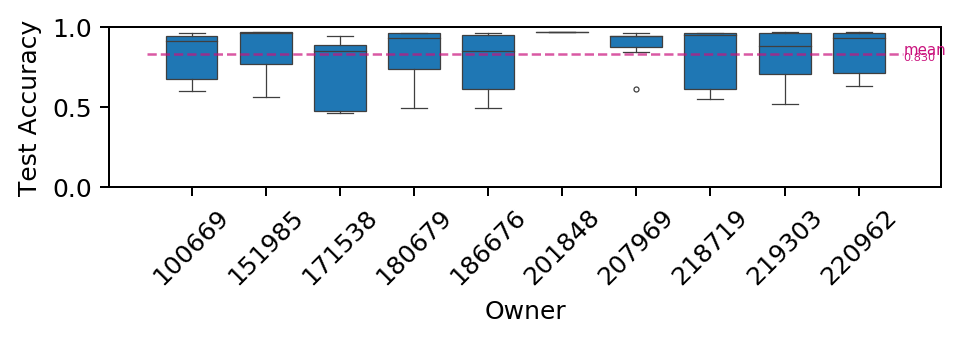

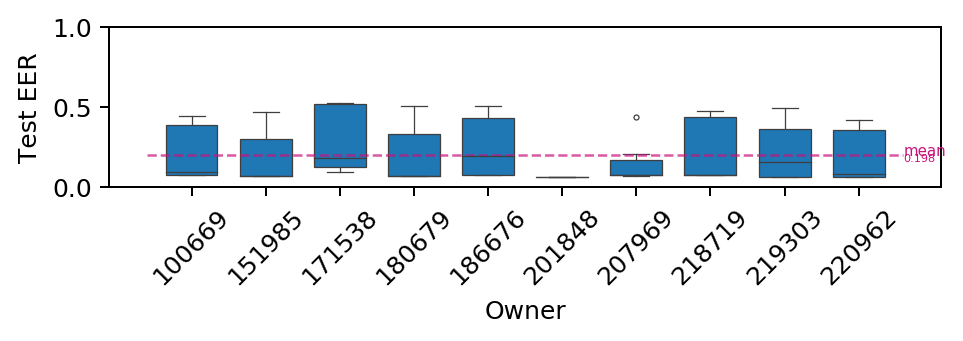

In [ ]:
def utils_plot_acc_eer_dist(df_plot, y_col):
    n_subject = len(df_plot["Owner"].unique()) - 1
    mean_col = df_plot[y_col].mean()

    fig = plt.figure(figsize=(5.473, 2), dpi=180)
    ax = sns.boxplot(x="Owner", y=y_col, data=df_plot, **utils_boxplot_style)
    ax.set_ylim((0, 1))

    plt.plot(
        [-0.6, n_subject + 0.6],
        [mean_col, mean_col],
        linestyle="dashed",
        linewidth=1,
        color=MAGENTA,
        alpha=0.7,
    )
    plt.text(n_subject + 0.6, mean_col, f"mean", fontsize=6, color=MAGENTA)
    plt.text(
        n_subject + 0.6, mean_col - 0.04, f"{mean_col:.3f}", fontsize=4.5, color=MAGENTA
    )
    plt.xticks(rotation=45)
    fig.tight_layout()
    
    print(f"Overall mean: {mean_col:.4f}")
    return fig
# Define a style I use a lot for boxplots:
utils_boxplot_style = dict(
    color="tab:blue",
    linewidth=0.5,
    saturation=1,
    width=0.7,
    flierprops=dict(
        marker="o", markersize=2, markerfacecolor="none", markeredgewidth=0.5
    ),
)
# print(df_results.head())
df_plot = df_results_eval.rename(
    columns={"test_accuracy": "Test Accuracy", "test_eer": "Test EER", "owner": "Owner"}
).astype({"Owner": str})
fig = utils_plot_acc_eer_dist(df_plot, "Test Accuracy")
utils_save_plot(fig,f"OCSVM_EVAL_{window_size}_{model_variant}_{hmog}.png")
fig = utils_plot_acc_eer_dist(df_plot, "Test EER")
